## Week 12 Homework (10)



### Q1: define

- Gaussian Processes (GPs) and stochastic processes generally
- Variational inference using the Evidence Lower Bound (ELBO)

### Q1 Answer

---

A stochastic process is a collection of random variables, indexed by some set (typically time or space), which describes how the random variables jointly evolve. Formally, a stochastic process $\{X_t\}_{t\in T}$ is a family of random variables where $t$ belongs to an index set $T$, such as time or spatial coordinates. Each $X_t$ is a random variable, and the process describes how these variables jointly behave.

A Gaussian Process (GP) is a specific type of stochastic process where any finite collection of the random variables in the process has a joint multivariate Gaussian distribution. A Gaussian Process is completely and fully specified by its mean function $\mu(x)$ and its covariance function (kernel function) $k(x,x')$

We have the following for Gaussian Processes: $f(x)\sim\text{Gaussian}\left(\mu(x),k(x,x')\right)$

---

Variational inference is an approach to approximate Bayesian inference, and is used when exact inference (computing the posterior) is not feasible. The idea is to approximate the true posterior with a simpler tractable distribution, by minimizing the Kullback-Leibler divergence between the simpler distribution and the true posterior. However, since the true posterior is usually difficult to work with, we instead maximize the Evidence Lower Bound (ELBO) -- this provides a lower bound on the log marginal likelihood. Maximizing the ELBO ensures that the variational distribution both fits the data well, and stays close to the true posterior.

---

### Q2: more GPs

Repurpose PyMC documentation to provide a demonstration of Gaussian processes for a different dataset context than the PyMC examples.

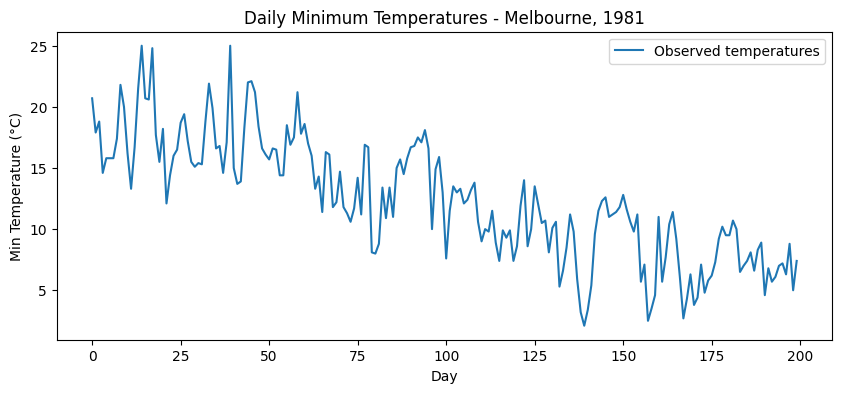

In [6]:
# Q2 Answer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url, parse_dates=['Date'])

# Prepare data
df = df.iloc[:200]  # Use only first 200 days for simplicity
X = (df['Date'] - df['Date'].min()).dt.days.values[:, None]  # Days as integers
y = df['Temp'].values

# Plot raw data
plt.figure(figsize=(10, 4))
plt.plot(X, y, label="Observed temperatures")
plt.xlabel("Day")
plt.ylabel("Min Temperature (°C)")
plt.title("Daily Minimum Temperatures - Melbourne, 1981")
plt.legend()
plt.show()

In [2]:
# Q2 Answer

with pm.Model() as gp_model:
    # Mean and covariance functions
    mean_func = pm.gp.mean.Zero()
    cov_func = pm.gp.cov.ExpQuad(1, ls=20.0)

    # Gaussian Process
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)

    # Noise term
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    # GP likelihood
    y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=sigma)

    # Inference
    trace = pm.sample(1000, chains=2, return_inferencedata=True)

/usr/local/lib/python3.11/dist-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


Output()

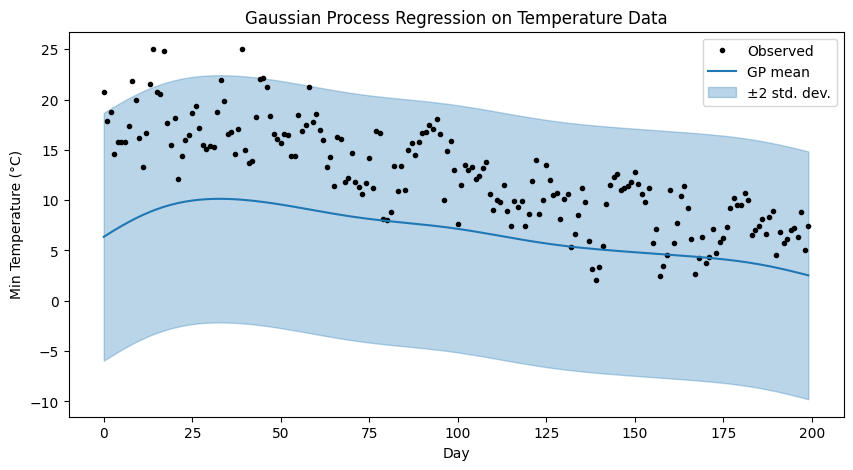

In [7]:
# Q2 Answer

# Create prediction grid
X_new = np.linspace(X.min(), X.max(), 200)[:, None]

# Extract posterior mean point including sigma
posterior_mean = trace.posterior.mean(dim=("chain", "draw"))
point = {
    "sigma": float(posterior_mean["sigma"].values),  # <-- this fixes it!
}

with gp_model:
    mu, var = gp.predict(X_new, point=point, diag=True, pred_noise=True)
    sd = np.sqrt(var)

# Plot GP posterior
plt.figure(figsize=(10, 5))
plt.plot(X, y, "k.", label="Observed")
plt.plot(X_new, mu, "C0", label="GP mean")
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="C0", alpha=0.3, label="±2 std. dev.")
plt.xlabel("Day")
plt.ylabel("Min Temperature (°C)")
plt.title("Gaussian Process Regression on Temperature Data")
plt.legend()
plt.show()


---

The plot above shows the results of a Gaussian Process regression model fit to 200 days of daily minimum temperature measurements in Melbourne, Australia. The black dots here represent the observed temperature values, while the blue curve represents the Gaussian Process' posterior mean prediction over time. The shaded blue regions indicate the model's uncertainty, showing +/- 2 standard deviations from the mean. This output illustrates how Gaussian Processes model both smooth trends and uncertainty in predictions.

This example differs from the synthetic/abstract examples typically shown in PyMC documentation by using real and noisy observation data. I treated the day number as the input variable and modeled the temperature as the Gaussian Process output, incorporating a noise term to account for observation error. After fitting the model, I generated posterior predictions across a range of days. The results show the Gaussian Process' ability to model the underlying temperature trend while providing credible intervals that reflect uncertainty (especially in regions where the data is sparse).

---

### Q3: more VI/ELBO

Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.

In [18]:
# Q3 Answer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=';')

# Features and target
X = df.drop(columns=["quality"]).values
y = df["quality"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train_scaled.astype("float32")
X_test_scaled = X_test_scaled.astype("float32")
y_train = y_train.astype("float32")

In [19]:
# Q3 Answer

import pymc as pm
import pytensor.tensor as at

n_features = X_train_scaled.shape[1]
n_hidden = 10

with pm.Model() as bnn_model:
    # Priors
    w1 = pm.Normal("w1", mu=0, sigma=1, shape=(X_train_scaled.shape[1], 10))
    b1 = pm.Normal("b1", mu=0, sigma=1, shape=(10,))
    w2 = pm.Normal("w2", mu=0, sigma=1, shape=(10,))
    b2 = pm.Normal("b2", mu=0, sigma=1)

    # Data containers for input and output
    x_input = pm.Data("x_input", X_train_scaled)
    y_target = pm.Data("y_target", y_train)

    # NN forward pass
    hidden = at.tanh(at.dot(x_input, w1) + b1)
    out = at.dot(hidden, w2) + b2

    # Likelihood (now flexible to match `y_target` shape)
    sigma = pm.HalfNormal("sigma", sigma=1.0)
    y_obs = pm.Normal("y_obs", mu=out, sigma=sigma, observed=y_target)

    # Fit with ADVI
    approx = pm.fit(10000, method="advi")

Output()

Output()

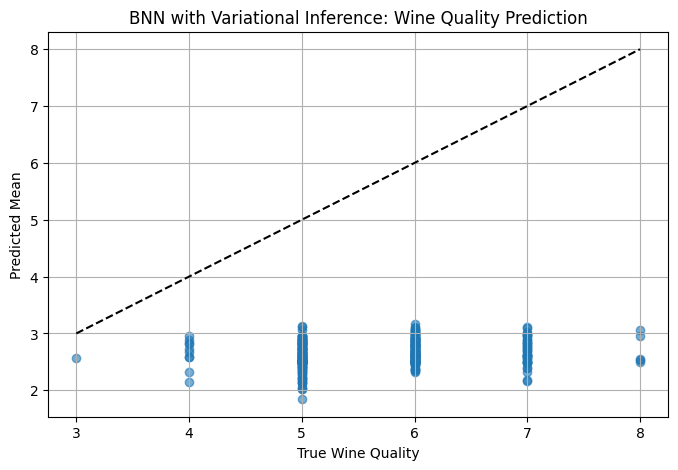

In [20]:
# Q3 Answer

# Sample from variational posterior
posterior = approx.sample(draws=500)

# Set test data before posterior predictive
with bnn_model:
    pm.set_data({"x_input": X_test_scaled, "y_target": np.zeros_like(y_test)})  # placeholder target
    posterior_predictive = pm.sample_posterior_predictive(posterior, var_names=["y_obs"])


# Plot predictions vs true values
preds = posterior_predictive.posterior_predictive["y_obs"].mean(dim=["chain", "draw"]).values.flatten()


plt.figure(figsize=(8, 5))
plt.scatter(y_test, preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("True Wine Quality")
plt.ylabel("Predicted Mean")
plt.title("BNN with Variational Inference: Wine Quality Prediction")
plt.grid(True)
plt.show()

---

In this example, I built a Bayesian neural network in PyMC to model the relationship between red wine’s physicochemical properties and its quality scores. Unlike standard neural networks, this model uses probabilistic weights and biases, enabling uncertainty quantification. I used a single hidden layer with normal priors and fit the model using variational inference via PyMC's ADVI (Automatic Differentiation Variational Inference), which optimizes the ELBO to approximate the posterior. After training, I generated predictions on a test set and visualized them against true values. The results demonstrate how variational inference can be effectively applied to Bayesian deep learning tasks.

---

References: used OpenAI to generate sections of code.